### **대치동**
    누군가 이 글을 본다면..
    변수 정리한거 적용은 나중에 하겠습니다
    다 만들어놓고 바꿀래요.......
    넘헷갈령ㅅ

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.options.display.float_format = '{:}'.format


---
##### **함수**
- 결측치 확인: find_missing_value(df)
- 이상치 확인: find_outlier(df, exclusions)
- 이상치 반환: return_outlier(df, exclusions)
- 이상치 제거한 데이터프레임 반환: remove_outliers(df, outliers_list)
##### **변수**
- 2023년 데이터프레임: 길단위인구_df_2023
- 이상치 탐색 시 사용하는 예외 칼럼 리스트: exclusions
- 상권_코드_명 중복 없는 리스트: 상권_list

In [75]:
# 결측치 수 출력하는 함수 생성
def find_missing_value(df):
    print("결측치 확인\n")
    
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count}")


In [76]:
# 이상치 확인하는 함수 생성
def find_outlier(df, exclusions=['기준_년분기_코드']):
    print("이상치 확인\n")
    
    for column in df.columns:
        if column in exclusions:
            continue
        
        # 1사분위수 및 3사분위수 계산
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        # IQR 계산
        iqr = q3 - q1
        
        # 이상치 경계 계산
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # 이상치 여부 판별
        outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
        if outlier.any():
            print(f"{column}| 1사분위수: %.2f, 3사분위수: %.2f" % (q1, q3))
            outliers = df.loc[outlier, ['상권_코드_명', '기준_년분기_코드', column]]
            for idx, row in outliers.iterrows():
                print(f"\t{row[column]}({row['상권_코드_명']} {row['기준_년분기_코드']})")
        else:
            print(f"{column}| 이상치 없음")


In [77]:
# 이상치 반환하는 함수 생성
def return_outlier(df, exclusions=['기준_년분기_코드']):
    outliers_list = []
    
    for column in df.columns:
        if column in exclusions:
            continue
        
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
        if outlier.any():
            outliers = df.loc[outlier, ['상권_코드_명', '기준_년분기_코드', column]]
            for idx, row in outliers.iterrows():
                # [상권_코드_명, 기준_년분기_코드, 이상치가 발견된 column, 이상치] 로 이루어진 list 생성
                outliers_list.append([row['상권_코드_명'], row['기준_년분기_코드'], column, row[column]])

    return outliers_list if outliers_list else None


In [78]:
# 이상치 제거한 데이터프레임을 반환하는 함수 생성
def remove_outliers(df, outliers_list):
    new_df = df.copy()
    
    for outlier in outliers_list:
        new_df = new_df.drop(new_df[(new_df['상권_코드_명'] == outlier[0]) & (new_df['기준_년분기_코드'] == outlier[1]) & (new_df[outlier[2]] == outlier[3])].index)
    
    return new_df


---
##### **파일 가져오기**

In [79]:
# 경로 설정

동 = '대치동'

유path = 동 + '(길단위인구).csv'
점path = 동 + '(점포).csv'
매path = 동 + '(추정매출).csv'


In [80]:
# csv 파일 읽어오기 (encoding = 'cp949')

유df = pd.read_csv(유path, encoding = 'cp949')
점df = pd.read_csv(점path, encoding = 'cp949')
매df = pd.read_csv(매path, encoding = 'cp949')


---
##### 졸려요

In [81]:
유df.columns


Index(['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '총_유동인구_수',
       '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수',
       '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
       '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수',
       '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수',
       '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수',
       '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object')

In [82]:
# 결측치 확인

find_missing_value(유df)


결측치 확인

기준_년분기_코드: 0
상권_구분_코드: 0
상권_구분_코드_명: 0
상권_코드: 0
상권_코드_명: 0
총_유동인구_수: 0
남성_유동인구_수: 0
여성_유동인구_수: 0
연령대_10_유동인구_수: 0
연령대_20_유동인구_수: 0
연령대_30_유동인구_수: 0
연령대_40_유동인구_수: 0
연령대_50_유동인구_수: 0
연령대_60_이상_유동인구_수: 0
시간대_00_06_유동인구_수: 0
시간대_06_11_유동인구_수: 0
시간대_11_14_유동인구_수: 0
시간대_14_17_유동인구_수: 0
시간대_17_21_유동인구_수: 0
시간대_21_24_유동인구_수: 0
월요일_유동인구_수: 0
화요일_유동인구_수: 0
수요일_유동인구_수: 0
목요일_유동인구_수: 0
금요일_유동인구_수: 0
토요일_유동인구_수: 0
일요일_유동인구_수: 0


In [83]:
# 이상치 확인

exclusions = ['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명']
find_outlier(유df, exclusions)


이상치 확인

총_유동인구_수| 1사분위수: 635078.00, 3사분위수: 1421842.00
	5502206(선릉역 20233)
	5426721(선릉역 20232)
	5348663(선릉역 20231)
남성_유동인구_수| 1사분위수: 326166.00, 3사분위수: 773532.00
	2757255(선릉역 20233)
	2742060(선릉역 20232)
	2711690(선릉역 20231)
여성_유동인구_수| 1사분위수: 312320.00, 3사분위수: 648309.00
	2744951(선릉역 20233)
	2684661(선릉역 20232)
	2636972(선릉역 20231)
연령대_10_유동인구_수| 이상치 없음
연령대_20_유동인구_수| 1사분위수: 80165.00, 3사분위수: 198429.00
	956298(선릉역 20233)
	949449(선릉역 20232)
	940361(선릉역 20231)
연령대_30_유동인구_수| 1사분위수: 84915.00, 3사분위수: 202373.00
	1283691(선릉역 20233)
	1316935(선릉역 20232)
	1290690(선릉역 20231)
연령대_40_유동인구_수| 1사분위수: 132742.00, 3사분위수: 256294.00
	1109403(선릉역 20233)
	1106298(선릉역 20232)
	1099499(선릉역 20231)
연령대_50_유동인구_수| 1사분위수: 87418.00, 3사분위수: 181800.00
	736766(선릉역 20233)
	731088(선릉역 20232)
	715438(선릉역 20231)
연령대_60_이상_유동인구_수| 1사분위수: 73120.00, 3사분위수: 146062.00
	684205(선릉역 20233)
	671141(선릉역 20232)
	655465(선릉역 20231)
시간대_00_06_유동인구_수| 1사분위수: 80794.00, 3사분위수: 235795.00
	865113(선릉역 20233)
	493325(도곡초등학교 20233)
	859690(선릉역 20232)


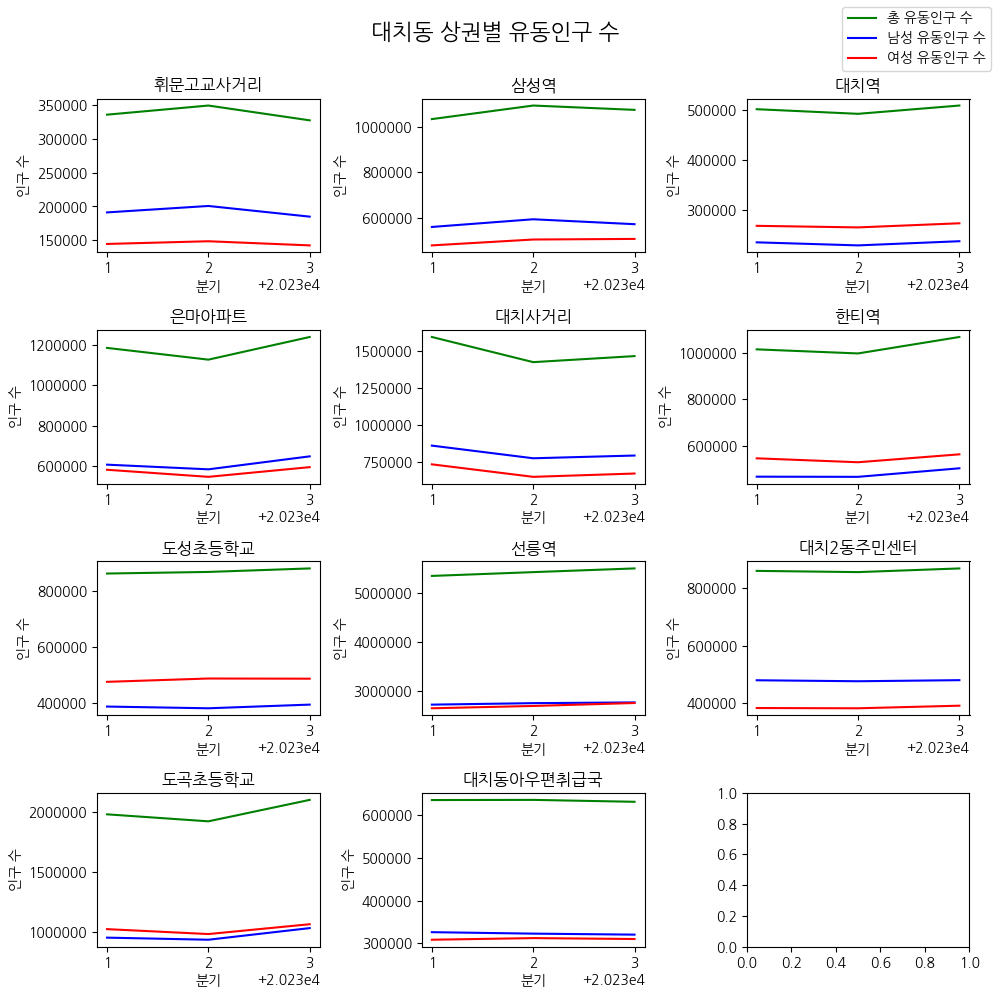

In [94]:
# 상권별 시각화

상권_list = 유df['상권_코드_명'].unique()

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (10, 10))
fig.suptitle(동 + ' 상권별 유동인구 수\n', fontsize = 16)
plt.rcParams['font.family'] = 'NanumGothic'

for idx, 상권 in enumerate(상권_list):
    ax = axes[idx // 3, idx % 3]
    
    상권_df = 유df[유df['상권_코드_명'] == 상권]
    
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '총_유동인구_수', ax = ax, color = 'g', legend = False)
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '남성_유동인구_수', ax = ax, color = 'b', legend = False)
    유df[유df['상권_코드_명'] == 상권].plot(x = '기준_년분기_코드', y = '여성_유동인구_수', ax = ax, color = 'r', legend = False)
    ax.set_title(상권)
    ax.set_xlabel('분기')
    ax.set_ylabel('인구 수')
    ax.ticklabel_format(style = 'plain', axis = 'y')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer = True))
        
fig.legend(['총 유동인구 수', '남성 유동인구 수', '여성 유동인구 수'], loc = 'upper right')

plt.tight_layout()
plt.show()


In [139]:
# 상권별 매출총액 / 유동인구

매총df = 매df.groupby(['상권_코드_명', '기준_년분기_코드'])['당월_매출_금액'].sum().reset_index()
유총df = 유df.groupby(['상권_코드_명', '기준_년분기_코드', '상권_구분_코드_명'])['총_유동인구_수'].sum().reset_index()

매총유총df = pd.merge(매총df, 유총df, on=['상권_코드_명', '기준_년분기_코드'], how = 'inner')
매총유총df['비율'] = (매총유총df['당월_매출_금액'] / 매총유총df['총_유동인구_수']).round(2)

# 분기별 비율 순으로 정렬하여 상권 종류별 최상위 상권 반환
최상위df = 매총유총df.groupby(['기준_년분기_코드', '상권_구분_코드_명']).apply(lambda x: x.loc[x['비율'].idxmax(), ['기준_년분기_코드', '상권_코드_명']]).reset_index(drop=True)
최상위df


,기준_년분기_코드,상권_코드_명
0,20231,대치2동주민센터
1,20231,삼성역
2,20232,대치2동주민센터
3,20232,삼성역
4,20233,대치동아우편취급국
5,20233,삼성역


가중치 부여를 해보아요!
1. 최상위df를 매df와 merge
2. 그걸 점df와 merge
3. 기준 년분기 코드, 상권 코드 명, 서비스 업종 코드 명, 당월 매출 금액, 점포 수만 남기기
4. 업종별 평균매출 = 당월 매출 금액 / 점포 수 로 새로운 칼럼 만들기
5. ['기준_년분기_코드', '상권_코드_명'] 으로 그룹바이 해서 각 그룹별 평균매출 상위 3개씩 반환
6. 서비스 업종 코드 명, 평균매출 가져와서 가중치 부여, 누적
누가 제안한건진 몰라도 정말 복잡하게도 만들었군

In [147]:
# 이거는ㅇ미완성임시코드입니다아악
병합된_df = pd.merge(매df, 최상위df, on=['기준_년분기_코드', '상권_코드_명'], how='inner')

# 필터링된 행만 선택하여 새로운 데이터프레임으로 반환
필터링된_매df = 병합된_df[['기준_년분기_코드', '상권_코드_명', '서비스_업종_코드_명', '당월_매출_금액']]
필터링된_매df
병합된_df[['기준_년분기_코드', '상권_코드_명', '서비스_업종_코드_명', '당월_매출_금액']]

,기준_년분기_코드,상권_코드_명,서비스_업종_코드_명,당월_매출_금액
0,20231,대치2동주민센터,한식음식점,1335780386
1,20231,대치2동주민센터,커피-음료,155425365
2,20231,삼성역,한식음식점,14265877727
3,20231,삼성역,중식음식점,8839407846
4,20231,삼성역,일식음식점,6322284973
5,20231,삼성역,양식음식점,4891209823
6,20231,삼성역,제과점,1057373610
7,20231,삼성역,패스트푸드점,178872564
8,20231,삼성역,치킨전문점,533803513
9,20231,삼성역,분식전문점,7633110851
